This script analyses SOO and MOO results.
It outputs EXCEL files and figures.
Plotting Pareto fronts for MOO currently only works with two objectives.

Author: Thomas Wortmann

In [4]:
import os
import pygmo as pg
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import statistics

Input Variables

Filepath to the folder with the logs.
The results will be written here as well.
The logs should be the only text files in that folder.

In [16]:
filePath = r"result_logs/"

C:\Users\Max\Downloads\result_logs\result_logs\\


Number of function evaluations to analyse. Choose a low number to speed up testing this script.


In [6]:
evals = 30

Set True for Minimization and False for maximization


In [7]:
bolMinimize = False

Log Name Settings (used to parse the solver from the log's file name)

In [8]:
log_name_limit = "_" # With what symbol should the file name be parsed?
log_name_solver = 2 # What part of the file name is the solver?

Figure Settings:
- Size in Inches
- Resolution
- Style
- Font

In [9]:
fig_size_convergence = (6.28, 4)
fig_size_robust = (6.28, 4)
fig_size_pareto = (12.56, 4)

figDPI = 300

fig_style ='seaborn-whitegrid'

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)

Dictionaries with solver names and colors for figures.
Change as needed

In [10]:
solverNameDict = {'nsga2':'NSGA-II','maco':'MACO', 'nspso':'NSPSO', 'moead':'MOEAD', 'RBFMOpt':'RBFMOpt', 'HypE':'HypE', 'SPEA2':'SPEA2', 'DIRECT':'DIRECT', 'CMAES':'CMA-ES', 'RBFOpt':'RBFOpt'}
solverColorDict = {'nsga2':'blue','maco':'orange', 'nspso':'green', 'moead':'red', 'RBFMOpt':'purple', 'HypE':'brown', 'SPEA2':'pink', 'DIRECT':'blue', 'CMAES':'red', 'RBFOpt':'purple'}

List with objectives names for Pareto front figure

In [11]:
objectiveNames = ['CEI', 'FAR']

Define Functions:

In [12]:
def parseObjs(filePath):
    '''Parse all objective from all logs in the file path'''
    allObjectives = []
    
    #Get text files 
    textFiles = []

    for file in os.listdir(filePath):
    	if file.endswith(".txt"):
    		textFiles.append(file)
    
    #Read in all objectives
    for i, fileName in enumerate(textFiles):
        
        with open(filePath + fileName, "r") as file:
            objectivesList = []
            
            for line in file:
                #End if maximum evaluations reached (for logs that are too long)
                if len(objectivesList) >= evals:
                    break
                
                words = line.split(" ")
                objectiveStrs = words[5].split(",")   
                objectives = list(map(lambda obj: float(obj), objectiveStrs))
                objectivesList.append(objectives)
            
            # Extend for missing log values
            if len(objectivesList) < evals:
                print(f"WARNING: {fileName} contains only {len(objectivesList)} evals instead of {evals}")
                
            while len(objectivesList) < evals:
                objectivesList.append(objectives)
                
            assert len(objectivesList) == evals
            allObjectives.extend(objectivesList)
        
    print(f"{i + 1}/{len(textFiles)} text files parsed")
    print(f"Parsed {evals} sets of {len(objectivesList[0])} objectives.")
    assert i + 1 == len(textFiles)
    assert len(allObjectives) == (i + 1) * evals
    
    return allObjectives

    
def findMinAndMaxPoints(objectivesList):
    # Note: Pygmo Ideal and Nadir can yield different results! (Report bug)
    '''Returns the min and max points for a list of sets of objectives'''        
    multipleObjectives = list(zip(*objectivesList))
       
    minPoint = np.array([min(objective) for objective in multipleObjectives])
    maxPoint = np.array([max(objective) for objective in multipleObjectives])
       
    print(f"MinPoint {minPoint}")
    print(f"MaxPoint {maxPoint}")
            
    return minPoint, maxPoint


def findParetoIs(objectivesList, bolMinimize):
    '''Returns a list of booleans corresponsing to sets of objectives.
    True is nondominates, False is dominated'''
      
    # Negate values for maximization
    if bolMinimize == False:
        minObjectivesList = []
         
        for objs in objectivesList:
            minObjectivesList.append(list(map(lambda y : y * -1, objs)))
    else:
        minObjectivesList = objectivesList
        
    # Dc is a list with domination counts, 0 == non-dominated
    ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(minObjectivesList)
    
    # Fill list with booleans
    nondominatedIs = []
    
    for count in dc:
        if count == 0:
            nondominatedIs.append(True)
        else:
            nondominatedIs.append(False)
    	
    return nondominatedIs


def calculateHypervolume(objectivesList, ideal_point, max_point, bolMinimize, bolNormalized):
    '''Calculate the current hypervolume.'''    
    # Negate values for maximization
    if bolMinimize == False:
        minObjectivesList = []
         
        # When objectives are normalized, invert them
        if bolNormalized:
            for objs in objectivesList:
                minObjectivesList.append(list(map(lambda y : 1 - y, objs)))
        # Else, multiply them by -1
        else:
            for objs in objectivesList:
                minObjectivesList.append(list(map(lambda y : -y, objs)))
    else:
        minObjectivesList = objectivesList
        
    # Choose reference point
    # When objectives are normalized, the reference is 1, 1, 1, ...

    if bolNormalized:
      ref_point = [1] * len(ideal_point)
    else:   
        # When objectives are minimized, the reference is the largest point
        if bolMinimize: 
            ref_point = max_point
        # When objectives are maximized, the reference is the smallest point
        # But multiplied by -1, because all values are multiplied by -1
        else:
            ref_point = ideal_point * -1

    hv = pg.hypervolume(minObjectivesList)
    return hv.compute(ref_point)


def recordObjective(obj, objectives, bolMinimized):
        print(obj)
        
        # First objective
        if len(objectives) == 0:
            return obj
        
        # Minimization
        if bolMinimized:
            if obj < objectives[-1]:
                return obj
            else:
                return objectives[-1]
            
        # Maximization
        if obj > objectives[-1]:
            return obj
        else:
            return objectives[-1]
   
                      
def normalizePoint(objectives, ideal_point, max_point):
    '''Normalize objectives based on the ideal (smallest) point 
    and the max (largest point).
    Ideal and max are unaffaect by minimization or maximization.
    Ideal and max should be supplied as numpy arrays.'''       
    range_point = np.array(max_point - ideal_point)
    normPoint = (np.array(objectives) - ideal_point) / range_point
    
    for obj in normPoint:
        assert(obj >= 0 and obj <= 1), f"\nObectives {objectives} \nNormalized {normPoint} \nMin {ideal_point} \nMax {max_point} \nRange {range_point}"
    
    return normPoint

            
def processLog(filePath, fileName, bolMinimize, bolMOO):
    secondsStart = 0

    parameters = []
    objectivesList = []
    normObjectivesList = []
    volume = []
    elapsed = []

    with open(filePath + fileName, "r") as file:
        for line in file:
            #End if maximum evaluations reached (for logs that are too long)
            if len(parameters) >= evals:
                break
            
            #Opossum Logs Settings	
            objectives, parameterStr, hrs, min, sec = splitOpossumLine(line, log_limit = " ", log_time = 1,  log_parameters = 3, log_objectives = 5)
            parameters.append(parameterStr)
            objectivesList.append(objectives)
            
            # For hypervolume calculation
            if bolMOO:
                normObjectivesList.append(normalizePoint(objectives, ideal_point, max_point)) 
            
            #Process time
            #print("hrs %f:hrs min %f:min sec %f:sec" % (hrs, min, sec))
            seconds = hrs * 3600 + min * 60 + sec
            
            #Set start time
            if len(elapsed) == 0:
                secondsStart = seconds
                prev_hrs = hrs
            #Check midnight (assumming 12H time format)
            if hrs < prev_hrs:
                seconds += 12 * 3600
                
            elapsed.append(seconds - secondsStart)
            
            
            # Calculate hypervolume for MOO 
            bolNormalized = True
            
            if bolMOO and bolNormalized:
                volume.append(calculateHypervolume(normObjectivesList, ideal_point, max_point, bolMinimize, True))		
            elif bolMOO:
                volume.append(calculateHypervolume(objectivesList, ideal_point, max_point, bolMinimize, False))
            # Record best objective for SOO
            else:
                volume.append(recordObjective(objectivesList[-1], volume, bolMinimize))
                
    # Extend values for logs that are too short
    while len(parameters) < evals:
            objectivesList.append(objectivesList[-1])
            parameters.append(parameters[-1])
            elapsed.append(elapsed[-1])
            volume.append(volume[-1])
    
    # Find non-dominated points for MOO
    if bolMOO:
        nondominatedIs = findParetoIs(objectivesList, bolMinimize)
    else:
        nondominatedIs = None

    print ("\n" + filePath + fileName)
    print ("Parameter: %d Objectives: %d Hypervolumes: %d Times: %d" % (len(parameters), len(objectives), len(volume), len(elapsed)))
    print ("Total time: " + str(elapsed[-1]) + " seconds Average iteration: " + str(round(elapsed[-1] / len(elapsed), 1)) + " seconds")
    print ("Best objective/hypervolume: " + str(volume[-1]))
    if bolMOO: print ("Pareto Indices: {} Nondominated: {} Dominated: {}".format(len(nondominatedIs), nondominatedIs.count(True), nondominatedIs.count(False)))
    
    assert len(volume) == evals
    
    return [fileName, elapsed, objectivesList, volume, nondominatedIs, parameters]


def splitOpossumLine(line, log_limit, log_time, log_parameters, log_objectives):
    words = line.split(log_limit)

    #Read objectives
    objectiveStrs = words[log_objectives].split(",")                
    objectives = list(map(lambda obj: float(obj), objectiveStrs))

    #Read parameters
    seperator = " "
    parameterStr = words[log_parameters]
    parameterStr = parameterStr.replace(",", seperator)
            
    #Read time
    times = words[log_time].split(":")
    #Process Time
    hrs = int(float(times[0]))
    min = int(float(times[1]))
    sec = int(float(times[2][:-1]))

    return(objectives, parameterStr, hrs, min, sec)

			
def getParetoDf(parameters, objectivesList, nondominatedIs, paretoDf = None, solverNames = None):    
    '''Returns a data frame per solver with the achieved Pareto fronts'''
    # First values is parameter string, then come values with objectives
    
    paretoValues = []
    
    for i, bol in enumerate(nondominatedIs):
        if bol == True and solverNames is None:
            paretoValues.append([parameters[i], *objectivesList[i]])
        elif bol == True:
            paretoValues.append([parameters[i], *objectivesList[i], solverNames[i]])
    
    # Sort the values by the first objective to form a continous front
    paretoValues = sorted(paretoValues, key = lambda paretoValue: paretoValue[1])
    
    newParetoDf = pd.DataFrame(paretoValues)
    
    # Generate column labels
    objN = len(objectivesList[0])
    
    if paretoDf is None:
        runI = 1
    else:
        columnN = len(paretoDf.columns)        
        runI = int(columnN / (objN + 1) + 1)
    
    columns = [f'Params{runI}']
    
    # Run index and Obj index
    for i in range(objN):
        columns.append(f'Obj{runI}_{i + 1}')
        
    # Solver names for best Pareto front
    if solverNames is not None:
        columns.append('Solver')
     
    newParetoDf.columns = columns 
    
    # Start new data frame for new solver
    if paretoDf is None:
        paretoDf = newParetoDf
    # Add to exisiting data frame
    else:
        paretoDf = pd.concat([paretoDf, newParetoDf], axis=1)
    
    #print(paretoDf[:5])
    return paretoDf


def processHypervolumeConvergence(hypervolumeDfs, solvers, bolMOO, bolMinimize, bolWriteExcel, bolPlot):
    '''Calculates the median hypervolume per function evaluation and solver.
    Returns data frame with the median hypervolume for each iteration and per solver'''
    print("\nProcessing convergence ...")
     
    # Median hypervolumes per iterations and solver
    allMedians= [hvDf.median(axis = 1).tolist() for hvDf in hypervolumeDfs]
    finalMedians = [median[-1] for median in allMedians]
    
    # Sort by performance    
    if bolMOO is False and bolMinimize is True:
        allMedians = [medians for median, medians in sorted(zip(finalMedians,allMedians), reverse = False)]     
        solvers = [solver for median, solver in sorted(zip(finalMedians,solvers), reverse = False)]
    else:
        allMedians = [medians for median, medians in sorted(zip(finalMedians,allMedians), reverse = True)]     
        solvers = [solver for median, solver in sorted(zip(finalMedians,solvers), reverse = True)]
    
    # Create dataframe with labelled columns 
    mediansDf = pd.DataFrame(allMedians).transpose()
    mediansDf.columns = [solverNameDict[solver] for solver in solvers]
    
    # Print last 5 rows
    print(mediansDf.tail(5))
    
    # Label
    if bolMOO is False:
        yLabel = 'Objective'
    else:
        yLabel = 'Hypervolume'
        
    # Lineplot    
    if bolPlot:
        matplotlib.style.use(fig_style)
        plt.figure() # New figure
        
        mediansDf.plot.line(
            figsize = fig_size_convergence,
            color = [solverColorDict[solver] for solver in solvers],
            xlabel = 'Function Evaluations', 
            ylabel = yLabel)
        
        plt.savefig(filePath + 'convergence.png', dpi = figDPI)
        
    # Export excel with results for line plot
    if bolWriteExcel:
        # Relabel columns
        mediansDf.to_excel(filePath + 'Convergence.xlsx',
                         sheet_name = 'Convergence',
                         index = False)
    
    return mediansDf
    

def processHypervolumeRobustness(hypervolumeDfs, solvers, bolMOO,  bolMinimize, bolWriteExcel, bolPlot):
    '''Returns data frame with final hypervolumes for each run and per solver.'''
    print("\nProcessing variance ...")
    
    variances = []
    results = []
            
    for i, hvDf in enumerate(hypervolumeDfs): 
        lastRow = hvDf.iloc[-1]
        variances.append(lastRow.var()) # Variance for console
        results.append(lastRow.tolist())
            
    # Sort by performance
    medians = [statistics.median(result) for result in results] 
    
    if bolMOO is False and bolMinimize is True:
        results = [result for median, result in sorted(zip(medians,results), reverse = False)]
        variances = [variance for median, variance in sorted(zip(medians,variances), reverse = False)]
        solvers = [solver for median, solver in sorted(zip(medians,solvers), reverse = False)]
    else:
        results = [result for median, result in sorted(zip(medians,results), reverse = True)]
        variances = [variance for median, variance in sorted(zip(medians,variances), reverse = True)]
        solvers = [solver for median, solver in sorted(zip(medians,solvers), reverse = True)]
    
    # Print variance 
    varsDf = pd.DataFrame(variances).transpose()
    varsDf.columns = solvers
    print('\nVariance')
    print(varsDf.transpose())
    
    # Create dataframe
    resultsDf = pd.DataFrame(results).transpose()
    resultsDf.columns = [solverNameDict[solver] for solver in solvers]
    
    # Boxplot
    # Label
    if bolMOO is False:
        yLabel = 'Objective'
    else:
        yLabel = 'Hypervolume'
    
    if bolPlot:
        plt.figure() # New figure
        matplotlib.style.use(fig_style)
        
        ax = resultsDf.plot(kind='box', figsize=fig_size_robust)
        ax.set_xlabel('Final Results')
        ax.set_ylabel(yLabel)
        
        plt.savefig(filePath + 'robustness.png', dpi = figDPI)

    # Export excel with results for box plot
    if bolWriteExcel:
        resultsDf.to_excel(filePath + "Robustness.xlsx",
                         sheet_name = "Robustness",
                         index = False)
        
    return resultsDf, medians
    

def processParetoFronts(paretoDfs, solvers, frontIs, medians, bestDf, bolWriteExcel, bolPlot):
    assert len(solvers) == len(paretoDfs), "\nSolvers {len(solvers)} Pareto Dataframes {len(paretoDfs)}"
    
    # Sort by performance    
    if bolMOO is False and bolMinimize is True:
        paretoDfs = [paretoDf for median,paretoDf in sorted(zip(medians,paretoDfs), reverse = False)]
        solvers = [solver for median,solver in sorted(zip(medians,solvers), reverse = False)]
        frontIs= [frontI for median,frontI in sorted(zip(medians,frontIs), reverse = False)]
    else:
        paretoDfs = [paretoDf for median,paretoDf in sorted(zip(medians,paretoDfs), reverse = True)]
        solvers = [solver for median,solver in sorted(zip(medians,solvers), reverse = True)]
        frontIs= [frontI for median,frontI in sorted(zip(medians,frontIs), reverse = True)]
        
    # Write Excel with one sheet per solver
    if bolWriteExcel:
        # Create a Pandas Excel writer using XlsxWriter as the engine.
        writer = pd.ExcelWriter(filePath + "ParetoFronts.xlsx")
                    
        for i, paretoDf in enumerate(paretoDfs):
            paretoDf.to_excel(writer,
                             sheet_name = solverNameDict[solvers[i]],
                             index = False)
        
        # Best Pareto front
        if bestDf is not None:
            bestDf.to_excel(writer,
                 sheet_name = 'bestKnown',
                 index = False)
                
        # Close the Pandas Excel writer and output the Excel file.
        writer.save()
    
    # For each solver, print the front of the run provided in frontIs
    # Typically, this should be the median run
    if bolPlot:
        plt.figure() # New figure
        matplotlib.style.use(fig_style)
        ax = None
               
        for i, paretoDf in enumerate(paretoDfs):
            # Find number of runs
            frontN = 0
            
            for columnLabel in paretoDf.columns:
                if len(columnLabel) > 6 and columnLabel[:6] == 'Params':
                    frontN += 1
            
            # Find number of objectives
            objN = int(len(paretoDf.columns) / frontN) - 1
                                
            # Plot lines
            ax = paretoDf.plot.line(
                x = 1 + ((objN + 1) * frontIs[i]),
                y = 2 + ((objN + 1) * frontIs[i]),
                ax = ax,
                color = solverColorDict[solvers[i]],
                label = solverNameDict[solvers[i]])
            # Plots points
            paretoDf.plot.scatter(
                x = 1 + ((objN + 1) * frontIs[i]),
                y = 2 + ((objN + 1) * frontIs[i]),
                ax = ax,
                color = 'white',
                edgecolors = solverColorDict[solvers[i]],
                xlabel = objectiveNames[0], 
                ylabel = objectiveNames[1])
        
        # Best Pareto front
        if bestDf is not None:
            # Plot lines
            bestDf.plot.line(
                figsize=fig_size_pareto,
                x = 1,
                y = 2,
                ax = ax,
                color = 'black',
                label = 'Best-known',
                dashes = (4,3))
            # Plots points
            bestDf.plot.scatter(
                x = 1,
                y = 2,
                ax = ax,
                color = 'white',
                edgecolors = 'black',
                xlabel = objectiveNames[0], 
                ylabel = objectiveNames[1])
        
        if bolMinimize is False:
            ax.invert_xaxis()
            ax.invert_yaxis()
            
        plt.savefig(filePath + 'pareto.png', dpi = figDPI)
            
            
def getMedianRunIs(resultsDf):
    '''Returns the index of the median run per solver.'''
    solvers = resultsDf.columns    
    mediansDf = resultsDf.median(axis = 0)
    assert mediansDf.size == len(solvers), f'Number of medians ({mediansDf.size}) doesnt match number of solvers({len(solvers)})'
    
    print('\nMedians')
    print(mediansDf.to_string())
    
    # Subtract median and find smallest difference
    indices = [abs(resultsDf[solver] - mediansDf[solver]).idxmin() for solver in solvers]
    
    print(f'\nMedian runs {indices}')
    return indices

Main


Parsing objectives ...
6/6 text files parsed
Parsed 30 sets of 1 objectives.

Single-objective
[1345.0906]
[1101.2683]
[1132.3245]
[1025.7513]
[1275.1514]
[1238.3429]
[987.6193]
[1308.3003]
[933.4749]
[1104.2749]
[1334.1445]
[1372.7422]
[1181.3565]
[1313.3625]
[968.7715]
[986.0212]
[1166.6406]
[1282.2176]
[1211.3595]
[1378.9005]
[999.0201]
[1096.0997]
[1071.6285]
[1229.2302]
[866.0104]
[1084.6318]
[1493.7346]
[1277.113]
[931.5934]
[1374.127]

C:\Users\Max\Downloads\result_logs\result_logs\\210503_SOO_CMAES_1.txt
Parameter: 30 Objectives: 1 Hypervolumes: 30 Times: 30
Total time: 664 seconds Average iteration: 22.1 seconds
Best objective/hypervolume: [1493.7346]
[1299.9663]
[1677.6796]
[1149.0858]
[1017.321]
[1341.6799]
[944.9397]
[1230.3261]
[1281.1303]
[1216.5431]
[998.9387]
[1188.5959]
[907.7285]
[912.4508]
[1185.9884]
[973.0449]
[929.4333]
[961.996]
[963.6983]
[1249.3769]
[1334.0278]
[977.2146]
[1096.2421]
[1139.2448]
[1283.3339]
[911.1028]
[1186.8794]
[1100.2911]
[998.1252]
[823.96

<Figure size 432x288 with 0 Axes>

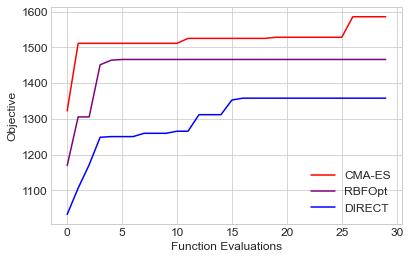

<Figure size 432x288 with 0 Axes>

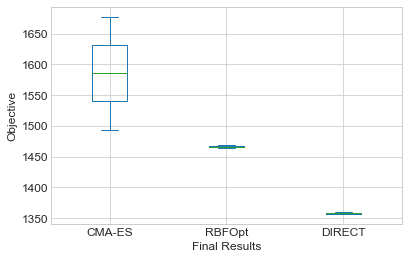

In [13]:
if __name__ == "__main__":
    prevSolverName = ''
    logLines = []
    
    multiObjs = []
    solverNames = []
    parameters = []
    
    #Dataframes for hypervolumes and pareto fronts
    hypervolumeDfs = []
    paretoDfs = []
    solvers = []
        
    # Find Ideal and Max for Hypervolume calculation
    # Find objective ranges
    print("\nParsing objectives ...")
    objectivesList = parseObjs(filePath)
    
    # Check if this is SOO or MOO
    if len(objectivesList[0]) > 1:
        bolMOO = True
        print("\nMulti-objective")
    else:
        bolMOO = False
        print("\nSingle-objective")
    
    # Very important for accurate Hypervolume calculation, 
    # should be minimum point as np_array
    if bolMOO:
        print("Finding ideal and max points ...")
        ideal_point, max_point = findMinAndMaxPoints(objectivesList)
    
    #Get text files 
    textFiles = []
    
    for file in os.listdir(filePath):
    	if file.endswith(".txt"):
    		textFiles.append(file)
    textFiles.sort()
    #Process text files
    for file in textFiles:
        solverName = (file.split(log_name_limit))[log_name_solver]
        logValues = processLog(filePath, file, bolMinimize, bolMOO)
        
        # New solver    
        if solverName not in solvers:        
            # Append data frame for previous solver
            if bolMOO and prevSolverName != '':
                    paretoDfs.append(paretoDf)
                    
            # Record new solver name
            solvers.append(solverName)
            prevSolverName = solverName
             
            # Start new pareto front data frame
            if bolMOO: paretoDf = getParetoDf(logValues[5],logValues[2],logValues[4], None)
                    
            # Start new data frame with hypervolume as columns
            hypervolumes = logValues[3]
            assert len(hypervolumes) == evals
            hypervolumeDfs.append(pd.DataFrame(data=hypervolumes))
            
    
        else:        
            # Extend hypervolume data frame
            hypervolumes = logValues[3]
            assert len(hypervolumes) == evals
            hypervolumeDfs[-1] = pd.concat([hypervolumeDfs[-1], pd.DataFrame(data=hypervolumes)], axis=1)   
            
            # Extend pareto front data frame for MOO
            if bolMOO: paretoDf = getParetoDf(logValues[5],logValues[2],logValues[4], paretoDf)
            
        #Store multi-objective values for best-know front calculation
        multiObjs.extend(logValues[2])
        parameters.extend(logValues[5])
        solverNames.extend([solverName for i in range(len(logValues[2]))])
    
    # Append last pareto front data frame
    if bolMOO: paretoDfs.append(paretoDf)
    
    # Process hypervolumes
    mediansDf = processHypervolumeConvergence(hypervolumeDfs, solvers, bolMOO, bolMinimize, bolWriteExcel = True, bolPlot = True)
    robustDf, medians = processHypervolumeRobustness(hypervolumeDfs, solvers, bolMOO, bolMinimize, bolWriteExcel = True, bolPlot = True)
    
    # Find best-known Pareto front for MOO
    if bolMOO:
        frontIs = getMedianRunIs(robustDf)
        totalEvals = len(textFiles) * evals
        print(f"\nEvaluations {totalEvals} Parameters {len(parameters)} Objectives {len(multiObjs)} Solver Names {len(solverNames)}")
        assert len(multiObjs) == totalEvals and len(solverNames) == totalEvals and len(parameters) == totalEvals
        print("Calculating best-known front ...")
        
        bolsNondom = findParetoIs(multiObjs, bolMinimize)
        bestDf = getParetoDf(parameters, multiObjs, bolsNondom, None, solverNames)
                
        # Process pareto fronts
        processParetoFronts(paretoDfs, solvers, frontIs, medians, bestDf, bolWriteExcel = True, bolPlot = True)    
    
    print(f"\nProcess complete, processed {len(textFiles)} logs") 